<a href="https://colab.research.google.com/github/ajiaja38/fruits_Clasification_MobileNet/blob/main/fruits_Clasification_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.12.0


In [ ]:
! chmod 600 /content/kaggle.json
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d aelchimminut/fruits262

100% 6.12G/6.13G [03:17<00:00, 39.5MB/s]
100% 6.13G/6.13G [03:17<00:00, 33.4MB/s]


In [ ]:
import zipfile,  os
zip_file = zipfile.ZipFile('/content/fruits262.zip')
zip_file.extractall('/data/')
zip_file.close()

In [ ]:
import shutil
raw_dataset_dir = '/data/Fruit-262/'
selected_folders = ['apple', 'avocado', 'banana', 'blueberry', 'carambola', 'cherry', 'coconut', 'dragonfruit', 'durian', 'grape', 'guava', 'kiwi', 'langsat', 'lemon', 'lychee', 'mango', 'mangosteen', 'orange', 'papaya', 'peanut', 'pear', 'rambutan', 'salak', 'strawberry', 'tomato']

all_folders = os.listdir(raw_dataset_dir)

# Delete folders
for folder in all_folders:
  folder_path = os.path.join(raw_dataset_dir, folder)

  if folder not in selected_folders:
    shutil.rmtree(folder_path)


In [ ]:
!pip install split-folders

In [ ]:
# Split folder
import splitfolders

base_dir = '/data/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

splitfolders.ratio('/data/Fruit-262', base_dir, seed=1, ratio=(.8, .2))

Copying files: 25751 files [00:20, 1266.05 files/s]


In [ ]:
train_dir = Path(train_dir)
validation_dir = Path(validation_dir)

train_filepaths = list(train_dir.glob('**/*.jpg'))
val_filepaths = list(validation_dir.glob('**/*.jpg'))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
train_df = image_processing(train_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {sorted(train_df.Label.unique())}')

-- Training set --

Number of pictures: 20591

Number of different labels: 25

Labels: ['apple', 'avocado', 'banana', 'blueberry', 'carambola', 'cherry', 'coconut', 'dragonfruit', 'durian', 'grape', 'guava', 'kiwi', 'langsat', 'lemon', 'lychee', 'mango', 'mangosteen', 'orange', 'papaya', 'peanut', 'pear', 'rambutan', 'salak', 'strawberry', 'tomato']


In [ ]:
train_df.head(20)

,Filepath,Label
0,/data/dataset/train/lemon/408.jpg,lemon
1,/data/dataset/train/cherry/685.jpg,cherry
2,/data/dataset/train/lemon/265.jpg,lemon
3,/data/dataset/train/avocado/703.jpg,avocado
4,/data/dataset/train/lemon/215.jpg,lemon
5,/data/dataset/train/guava/913.jpg,guava
6,/data/dataset/train/lemon/151.jpg,lemon
7,/data/dataset/train/apple/928.jpg,apple
8,/data/dataset/train/banana/1136.jpg,banana
9,/data/dataset/train/coconut/265.jpg,coconut


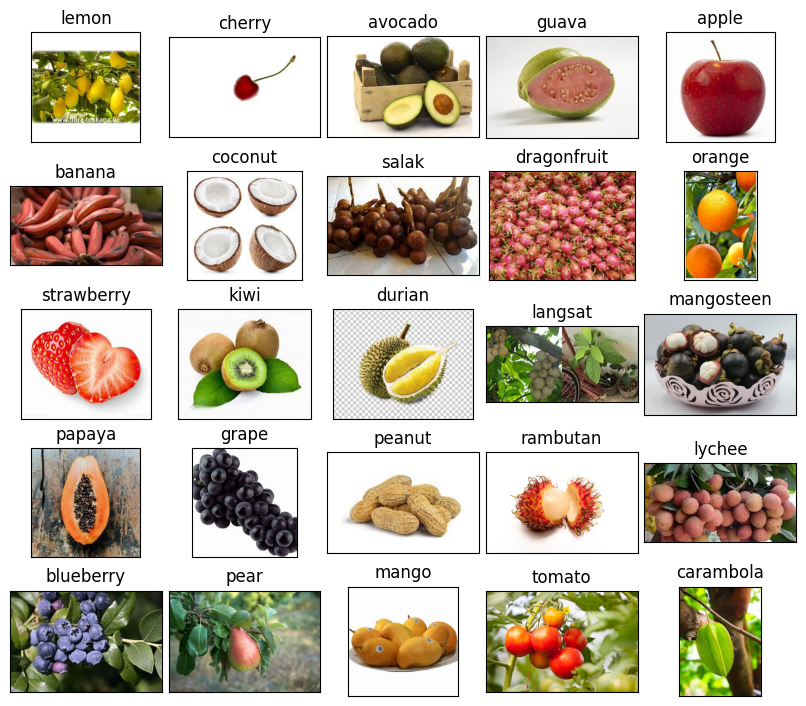

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'wrap')

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 20591 images belonging to 25 classes.


In [ ]:
val_images = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 5160 images belonging to 25 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(25, activation='softmax')
])

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                         

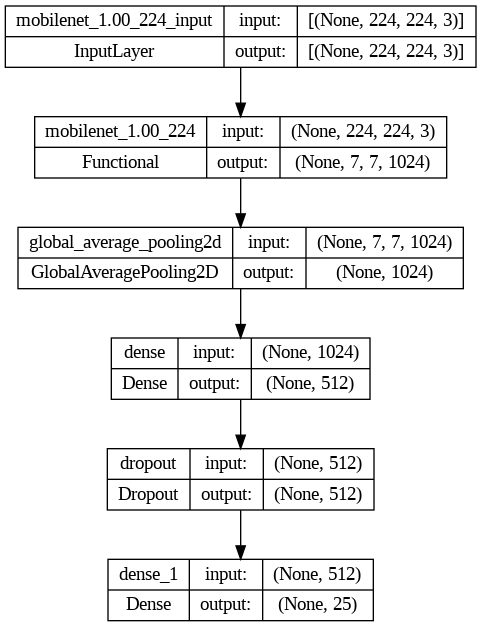

In [ ]:
# Model Visualization

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print('\n Training Model Berhenti, Nilai akurasi berada diatas 95%')
      self.model.stop_training = True
callback = Callback()

In [ ]:
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_images,
    batch_size = 32,
    callbacks=[callback]
)

Epoch 1/20
644/644 [==============================] - 343s 488ms/step - loss: 0.9522 - accuracy: 0.7258 - val_loss: 1.0688 - val_accuracy: 0.7298
Epoch 2/20
644/644 [==============================] - 323s 501ms/step - loss: 0.5866 - accuracy: 0.8298 - val_loss: 1.1492 - val_accuracy: 0.7231
Epoch 3/20
644/644 [==============================] - 311s 484ms/step - loss: 0.4896 - accuracy: 0.8529 - val_loss: 0.6501 - val_accuracy: 0.8174
Epoch 4/20
644/644 [==============================] - 306s 475ms/step - loss: 0.4146 - accuracy: 0.8815 - val_loss: 0.6056 - val_accuracy: 0.8366
Epoch 5/20
644/644 [==============================] - 311s 483ms/step - loss: 0.3779 - accuracy: 0.8880 - val_loss: 0.4459 - val_accuracy: 0.8746
Epoch 6/20
644/644 [==============================] - 305s 473ms/step - loss: 0.3381 - accuracy: 0.8993 - val_loss: 0.3814 - val_accuracy: 0.8917
Epoch 7/20
644/644 [==============================] - 315s 488ms/step - loss: 0.3085 - accuracy: 0.9086 - val_loss: 0.5112 -

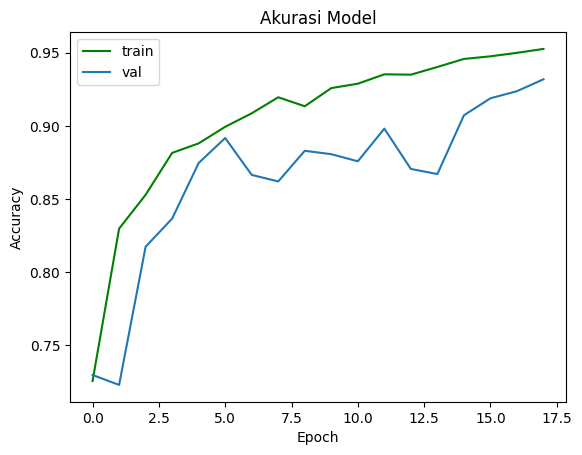

In [ ]:
# Plot Kurva Akurasi dan Loss Model training
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(accuracy, color='green')
plt.plot(val_accuracy)
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

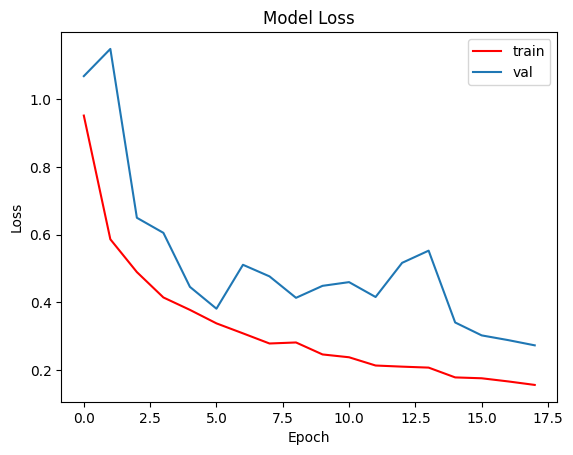

In [ ]:
plt.plot(loss, color='red')
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

# Path ke gambar yang akan diprediksi
image_path = '/data/dataset/val/blueberry/196.jpg'

# Load gambar
img = image.load_img(image_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi data gambar
img_array /= 255.0

# Prediksi menggunakan model
predictions = model.predict(img_array)

# Mengambil indeks dengan nilai maksimum
predicted_index = np.argmax(predictions)

# Mengonversi indeks menjadi label kelas menggunakan kamus labels
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
predicted_label = labels[predicted_index]

# Menampilkan label prediksi
print("Predicted label:", predicted_label)


1/1 [==============================] - 0s 21ms/step
Predicted label: blueberry


In [ ]:
def output(location):
    img=load_img(location,target_size=(100,100,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('/content/jeruk.jpg')
img

1/1 [==============================] - 0s 33ms/step


'orange'

In [ ]:
# Save Model
model.save('model.h5')